# Introdução às Redes Neurais Recorrentes (Dia 04) Picture1.jpg

---
## Introdução (Exemplo 1)

**Objetivo:** construir uma rede neural recorrente (LSTM) que seja capaz de fazer uma análise de sentimentos em reviews de filmes do IMDB.

* Este é um conjunto de dados de 50.000 avaliações de filmes do IMDB, rotuladas por sentimento (positivo/negativo). As avaliações foram pré-processadas, e cada avaliação é codificada como uma lista de índices de palavras (inteiros). Por conveniência, as palavras são indexadas pela frequência geral no conjunto de dados, de modo que, por exemplo, o inteiro "3" codifica a 3ª palavra mais frequente nos dados. Isso permite operações de filtragem rápidas, como: "considere apenas as 10.000 palavras mais comuns, mas elimine as 20 palavras mais comuns".

---
Como de costume, iniciamos carregando o que é necessário. Novamente vamos utilizar o `keras` como base.

Nome que aqui, nas camadas estamos chamando os módulos `Embedding` e `LSTM`.

Já o módulo `Embedding` será necessário para tratar as informações que no nosso caso são palavras (codificadas).

In [ ]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

---
Vamos carregar o banco de dados e separar o que é treino e teste. Além disso daremos uma verificada nos dados.

Note o parâmetro `max_features`. Ele significa que mantemos apenas as 10.000 palavras mais comuns nos dados de treinamento.

O conjunto de treino e teste neste dataset possuem o mesmo tamanho: 25.000 amostras de críticas.



In [ ]:
# Carrega o dataset do IMDB
max_features = 10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Checando os tensores
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
(25000,)
(25000,)
(25000,)
(25000,)


---
Agora precisamos fazer um breve tratamento nas sequências de texto.

Vamos fazer com que todos os textos de entrada tenham no máximo 500 palavras. Se o texto tem mais de 500, ele será cortado. Se ele tiver menos de 500 palavras ele será preenchido com zeros, através do método `pad_sequences`.

In [ ]:
maxlen = 500  # Número máximo de palavras por texto

# Preenche ou corta as sequências para que todas tenham o mesmo comprimento
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

---
Antes de continuarmos, algumas breves palavras sobre a **incorporação de palavras** (*word embedding*)

* A incorporação de palavras é uma técnica usada para representar palavras como vetores numéricos em um espaço de alta dimensão, tipicamente 50-300 dimensões.

* O seu objetivo é capturar o significado semântico das palavras e seus relacionamentos com outras palavras na linguagem.

* A incorporação de palavras revolucionou o processamento da linguagem natural e levou a melhorias significativas em muitas tarefas de NPL.

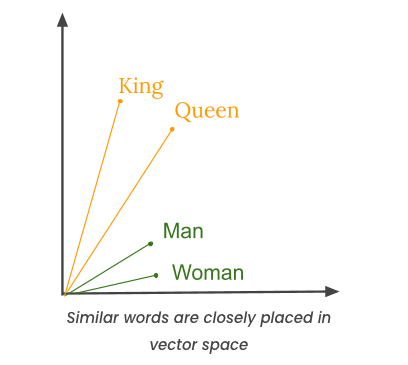

---
Finalmente, vamos criar o modelo.

* Aqui vamos criar uma rede na forma many-to-one.
* Usamos também o método `Sequential()` para criarmos uma rede recorrente. A classe `Sequential()` agrupa sequencialmente uma pilha linear de camadas em um modelo e pelo esquemático esse é o tipo adequado para as redes recorrentes.
* Para o caso tratado, a rede inicialmente deve ter uma camada de incorporação `Embedding`. Essa camada tem como objetivo transformar os inteiros, que representam as palavras dos textos, em vetores densos do tamanho escolhido.
* Em seguida, trazemos a camada `LSTM` e escolhemos uma quantidade de unidades que existirão na rede. Observe que o tamanho do vetor que sairá da incorporação é o mesmo da quantidade de unidades que iremos utilizar. Note que escolhemos utilizar uma regularização `Dropout` neste exemplo.
* Finalmente, na última parte vem uma camada densa com apenas 1 neurônio, que será a saída, e a função de ativação é uma `sigmoid` (que fornecerá uma probabilidade para o texto de entrada).

In [ ]:
# Parâmetros
embedding_size = 128  # Tamanho do vetor de incorporação
lstm_units = 128  # Número de unidades na LSTM
batch_size = 64  # Tamanho do lote
epochs = 4  # Número de épocas

# Define o modelo
model = Sequential()

# Camada de incorporação
model.add(Embedding(input_dim=max_features, output_dim=embedding_size))

# Duas camadas LSTM com dropout
# É necessário colocar return_sequences=True para que a saída dos estados
# ocultos da primeira camada seja entrada para a próxima camada
model.add(LSTM(units=lstm_units, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=lstm_units))
model.add(Dropout(0.2))

# Camada totalmente conectada (densa) com um único neurônio e ativação sigmoide
# A ativação sigmoide é usada porque este é um problema de classificação binária (sentimento positivo ou negativo)
model.add(Dense(units=1, activation='sigmoid'))

---
Para compilar o modelo, vamos usar uma função de perda nova: `binary_crossentropy`. Perceba que o nome é adequado, uma vez que temos apenas duas classes, positivo ou negativo. Sua fórmula é dada por
$$\mathcal{L}(\theta)=-\frac{1}{m}\sum_i \left\{\ln y_1 \ln(p(y_i))+(1-y_i)\ln(1-p(y_1))\right\}.$$

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

---
Uma olhadinha na estrutura da rede...

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

---
Hora de treinar o modelo.

*Obs*: aqui se não usar uma GPU vai demorar um bocado!

In [ ]:
# treina o modelo
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

# avalia o modelo
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

print(f'Perda do teste: {test_loss}')
print(f'Acurácia do teste: {test_accuracy}')

Epoch 1/4
391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 66ms/step - accuracy: 0.7068 - loss: 0.5566 - val_accuracy: 0.8602 - val_loss: 0.3235
Epoch 2/4
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - accuracy: 0.8947 - loss: 0.2712 - val_accuracy: 0.8656 - val_loss: 0.3145
Epoch 3/4
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 67ms/step - accuracy: 0.9067 - loss: 0.2370 - val_accuracy: 0.7915 - val_loss: 0.5017
Epoch 4/4
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 67ms/step - accuracy: 0.8608 - loss: 0.3252 - val_accuracy: 0.8576 - val_loss: 0.3593
Perda do teste: 0.3592853844165802
Acurácia do teste: 0.8575999736785889


---
Finalmente, vamos ver se o modelo é capaz de identificar a categoria de duas críticas que criei.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenizador baseado no índice de palavras do dataset do IMDB
word_index = imdb.get_word_index()
tokenizer = Tokenizer(num_words=max_features)
tokenizer.word_index = {k: (v + 3) for k, v in word_index.items()}
tokenizer.word_index["<PAD>"] = 0
tokenizer.word_index["<START>"] = 1
tokenizer.word_index["<UNK>"] = 2
tokenizer.word_index["<UNUSED>"] = 3

# Preprocessamos a frase desejada, em inglês (infelizmente)
custom_text1 = ["very nice movie. i loved every minute. one of the most beautiful piece of art ever."]  # tudo em caixa baixa
custom_text2 = ["terrible movie. i hated every minute of it. a waste of time and garbage overall."]  # tudo em caixa baixa
sequences1 = tokenizer.texts_to_sequences(custom_text1)
padded_sequence1 = pad_sequences(sequences1, maxlen=maxlen)
prediction1 = model.predict(padded_sequence1)

# Interpreta a previsão da primeira crítica
if prediction1 > 0.5:
    print(f"Sentimento positivo com confiança {prediction1[0][0]:.2f}")
else:
    print(f"Sentimento negativo com confiança {1 - prediction1[0][0]:.2f}")

sequences2 = tokenizer.texts_to_sequences(custom_text2)
padded_sequence2 = pad_sequences(sequences2, maxlen=maxlen)
prediction2 = model.predict(padded_sequence2)

# Interpreta a previsão da segunda crítica
if prediction2 > 0.5:
    print(f"Sentimento positivo com confiança {prediction2[0][0]:.2f}")
else:
    print(f"Sentimento negativo com confiança {1 - prediction2[0][0]:.2f}")

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Sentimento positivo com confiança 0.99
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Sentimento negativo com confiança 0.98


---
Veremos como modificar levemente a nossa rede construíndo uma rede recorrente, porém Bidirecional.

In [ ]:
from keras.layers import Bidirectional

model2 = Sequential()
model2.add(Embedding(input_dim=max_features, output_dim=embedding_size))
model2.add(Bidirectional(LSTM(units=lstm_units)))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

test_loss2, test_accuracy2 = model2.evaluate(x_test, y_test, verbose=0)
print(f'Perda do teste: {test_loss2}')
print(f'Acurácia do teste: {test_accuracy2}')


Epoch 1/4
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 70ms/step - accuracy: 0.6995 - loss: 0.5444 - val_accuracy: 0.8237 - val_loss: 0.4081
Epoch 2/4
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 68ms/step - accuracy: 0.8488 - loss: 0.3601 - val_accuracy: 0.8221 - val_loss: 0.4012
Epoch 3/4
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - accuracy: 0.8689 - loss: 0.3172 - val_accuracy: 0.8574 - val_loss: 0.3540
Epoch 4/4
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - accuracy: 0.9205 - loss: 0.2098 - val_accuracy: 0.8646 - val_loss: 0.3535
Perda do teste: 0.35353395342826843
Acurácia do teste: 0.8646399974822998


---
Finalmente, verifica o resultado das críticas que escolhemos para testar.

In [ ]:
prediction3 = model2.predict(padded_sequence1)
prediction4 = model2.predict(padded_sequence2)

# Fornece as previsões
if prediction3 > 0.5:
    print(f"Sentimento positivo com confiança {prediction3[0][0]:.2f}")
else:
    print(f"Sentimento negativo com confiança {1 - prediction3[0][0]:.2f}")

if prediction4 > 0.5:
    print(f"Sentimento positivo com confiança {prediction4[0][0]:.2f}")
else:
    print(f"Sentimento negativo com confiança {1 - prediction4[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Sentimento positivo com confiança 0.99
Sentimento negativo com confiança 0.99
